# Method: LSTM 
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. LSTM Implementation

In [19]:
def LSTM(h_dim, data_dim, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """
    
    def init_fun(rng):
        """
        This function initialize the weights of the RNN
        
        args:
        ====
         rng: jax RNG
         
        outputs:
        ======
         params: a tuple of parameters
        """
        
        # Forget Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        fU = W_init(k1, (h_dim, data_dim))
        fW = W_init(k2, (h_dim, h_dim)) 
        fb = b_init(k3, (h_dim,))
        
        # Input Layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        iU = W_init(k1, (h_dim, data_dim))
        iW = W_init(k2, (h_dim, h_dim))
        ib = b_init(k3, (h_dim,))
        
        # Candidate layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        gU = W_init(k1, (h_dim, data_dim))
        gW = W_init(k2, (h_dim, h_dim))
        gb = b_init(k3, (h_dim,))
        
        # Output layer
        k1, k2, k3 = jax.random.split(rng, num = 3)
        oU = W_init(k1, (h_dim, data_dim))
        oW = W_init(k2, (h_dim, h_dim))
        ob = b_init(k3, (h_dim,))
        
        # Dense layer (hidden -> y)
        k1, k2 = jax.random.split(rng, num = 2)
        dO = W_init(k1, (data_dim, h_dim))
        db = b_init(k2, (data_dim,))
                
        params = fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db
        return params
    
    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state
        
        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)
         
        outputs:
        =======
         c_final: jax vector of dimension nn_size
         h_final: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        c_zero = np.zeros((h_dim, ))
        h_zero = np.zeros((h_dim, ))
        
        # forward pass
        def process_internal(start, x):
            c, h = start
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, h) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, h) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, h) + gb)
            c_new = forget_gate * c + input_gate * cand_gate
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, h) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new), y
        (c_final, h_final), pred_traj = jax.lax.scan(process_internal, (c_zero, h_zero), time_series)
        return (c_final, h_final), pred_traj[-1]
    
    
    def forecast(params, internal_states, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.
        
        args:
        ====
         params: tuple of parameters
         internal_states = (c_internal, h_internal): internal state values of c and h
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction
         
        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        c_internal, h_internal = internal_states
        # extract parameters
        fU, fW, fb, iU, iW, ib, gU, gW, gb, oU, oW, ob, dO, db = params 
        
        # forward pass
        def forecast_internal(triple_c_h_x, _ ):
            cell, hidden, x = triple_c_h_x
            
            forget_gate = sigmoid(jnp.dot(fU, x) + jnp.dot(fW, hidden) + fb)
            input_gate = sigmoid(jnp.dot(iU, x) + jnp.dot(iW, hidden) + ib)
            cand_gate = jnp.tanh(jnp.dot(gU, x) + jnp.dot(gW, hidden) + gb)
            c_new = forget_gate * cell + input_gate * cand_gate
            output_gate = sigmoid(jnp.dot(oU, x) + jnp.dot(oW, hidden) + ob)
            h_new = jnp.tanh(c_new) * output_gate
            y = x + dO @ h_new + db
            
            return (c_new, h_new, y), y
        
        _, pred_traj = jax.lax.scan(forecast_internal, (c_internal, h_internal, x_input), None, length=horizon)
        
        # return the trajectory of predictions
        return pred_traj
    
    return init_fun, process, forecast

In [20]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1.):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = x[t_past_batch_val]
        y_val = y[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 100):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize LSTM
    init_fun, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [21]:
def get_test_pred(data_test, params, lstm_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = lstm_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [22]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-2, 1e-3, 1e-4] # Learning rate schedule
epoch_list = [200, 400, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [23]:
nn_size = 100

In [24]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 10: Time taken = 2.24 | Train loss = 0.0010682 | Val loss =  1.3406067
Epoch 20: Time taken = 2.29 | Train loss = 0.0005291 | Val loss =  1.1652263
Epoch 30: Time taken = 2.30 | Train loss = 0.0004044 | Val loss =  1.2564453
Epoch 40: Time taken = 2.53 | Train loss = 0.0003479 | Val loss =  1.1310668
Epoch 50: Time taken = 2.35 | Train loss = 0.0003215 | Val loss =  1.1666349
Epoch 60: Time taken = 2.41 | Train loss = 0.0002926 | Val loss =  1.1079464
Epoch 70: Time taken = 2.40 | Train loss = 0.0002716 | Val loss =  1.1224762
Epoch 80: Time taken = 2.37 | Train loss = 0.0002492 | Val loss =  1.1441799
Epoch 90: Time taken = 2.38 | Train loss = 0.0002475 | Val loss =  1.0584283
Epoch 100: Time taken = 2.45 | Train loss = 0.0002247 | Val loss =  1.1128178
Epoch 110: Time taken = 2.44 | Train loss = 0.0002225 | Val loss =  1.0911771
Epoch 120: Time taken = 2.39 | Train loss = 0.0004637 | Val loss =  1.0972936
Epoch 123: Time taken = 2.34 | Train loss = 0.0002

In [25]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.75


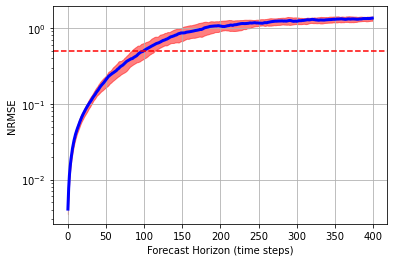

It takes around t = 1.00 for mean error to exceed 0.5


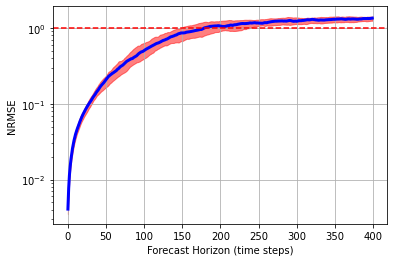

It takes around t = 1.79 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.073
Median NRMSE at t = 0.5: 0.208
Median NRMSE at t = 1: 0.506
Median NRMSE at t = 2: 1.060
Median NRMSE at t = 3: 1.227


In [26]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [27]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [28]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.47 | Train loss = 0.0008255 | Val loss =  1.3170280
Epoch 20: Time taken = 3.36 | Train loss = 0.0003252 | Val loss =  1.1766100
Epoch 30: Time taken = 3.37 | Train loss = 0.0001781 | Val loss =  1.0849142
Epoch 40: Time taken = 3.37 | Train loss = 0.0001159 | Val loss =  1.1056602
Epoch 50: Time taken = 3.37 | Train loss = 0.0000886 | Val loss =  0.9892823
Epoch 60: Time taken = 3.37 | Train loss = 0.0000655 | Val loss =  1.0227407
Epoch 70: Time taken = 3.38 | Train loss = 0.0000519 | Val loss =  0.8922182
Epoch 80: Time taken = 3.38 | Train loss = 0.0000403 | Val loss =  0.9118207
Epoch 90: Time taken = 3.38 | Train loss = 0.0000393 | Val loss =  0.8464678
Epoch 100: Time taken = 3.37 | Train loss = 0.0000287 | Val loss =  0.9326500
Epoch 107: Time taken = 3.38 | Train loss = 0.0000287 | Val loss =  0.7657450
Epoch 110: Time taken = 3.37 | Train loss = 0.0000231 | Val loss =  0.8067250
Epoch 120: Time taken = 3.37 | Train loss = 0.0000

In [29]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.81


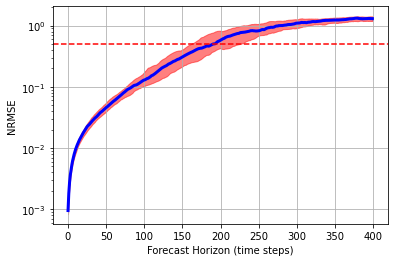

It takes around t = 1.91 for mean error to exceed 0.5


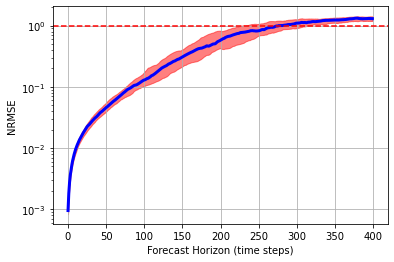

It takes around t = 2.78 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.018
Median NRMSE at t = 0.5: 0.046
Median NRMSE at t = 1: 0.129
Median NRMSE at t = 2: 0.578
Median NRMSE at t = 3: 1.095


In [30]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [31]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [32]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 8.43 | Train loss = 0.0004812 | Val loss =  1.1732334
Epoch 20: Time taken = 8.46 | Train loss = 0.0002049 | Val loss =  1.1522205
Epoch 30: Time taken = 8.46 | Train loss = 0.0001070 | Val loss =  1.1031917
Epoch 40: Time taken = 8.46 | Train loss = 0.0000671 | Val loss =  1.0340832
Epoch 50: Time taken = 8.45 | Train loss = 0.0000452 | Val loss =  0.9346176
Epoch 60: Time taken = 8.47 | Train loss = 0.0000376 | Val loss =  0.9237574
Epoch 70: Time taken = 8.47 | Train loss = 0.0000323 | Val loss =  0.9017195
Epoch 80: Time taken = 8.46 | Train loss = 0.0000255 | Val loss =  0.8907428
Epoch 90: Time taken = 8.46 | Train loss = 0.0000316 | Val loss =  0.8140647
Epoch 100: Time taken = 8.44 | Train loss = 0.0000183 | Val loss =  0.8683416
Epoch 104: Time taken = 8.44 | Train loss = 0.0000167 | Val loss =  0.7433347
Epoch 110: Time taken = 8.44 | Train loss = 0.0000149 | Val loss =  0.8044257
Epoch 120: Time taken = 8.44 | Train loss = 0.0000

In [33]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 1.28


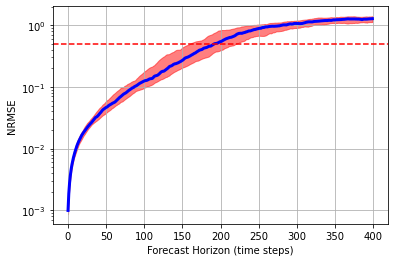

It takes around t = 1.92 for mean error to exceed 0.5


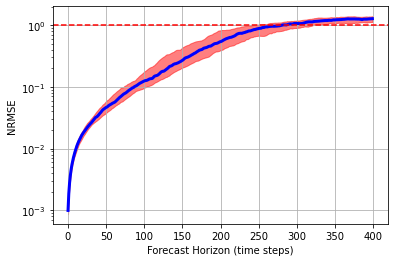

It takes around t = 2.80 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.018
Median NRMSE at t = 0.5: 0.047
Median NRMSE at t = 1: 0.125
Median NRMSE at t = 2: 0.542
Median NRMSE at t = 3: 1.065


In [34]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [35]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [36]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 15.94 | Train loss = 0.0004059 | Val loss =  1.2147084
Epoch 20: Time taken = 15.94 | Train loss = 0.0001746 | Val loss =  1.1241730
Epoch 30: Time taken = 15.92 | Train loss = 0.0000915 | Val loss =  1.0230662
Epoch 40: Time taken = 15.93 | Train loss = 0.0000591 | Val loss =  0.9754546
Epoch 50: Time taken = 15.93 | Train loss = 0.0000479 | Val loss =  0.9444032
Epoch 60: Time taken = 15.90 | Train loss = 0.0000350 | Val loss =  0.9260992
Epoch 70: Time taken = 15.96 | Train loss = 0.0000247 | Val loss =  0.8341671
Epoch 80: Time taken = 15.92 | Train loss = 0.0000205 | Val loss =  0.8339077
Epoch 90: Time taken = 15.91 | Train loss = 0.0000265 | Val loss =  0.8249404
Epoch 100: Time taken = 15.94 | Train loss = 0.0000176 | Val loss =  0.8164700
Epoch 105: Time taken = 15.93 | Train loss = 0.0000167 | Val loss =  0.7589555
Epoch 110: Time taken = 15.92 | Train loss = 0.0000134 | Val loss =  0.7964125
Epoch 120: Time taken = 15.90 | Train 

In [37]:
mean_pred = get_test_pred(X_test, params, lstm_fx)
# save_obj(mean_pred, "results/lstm", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 2.12


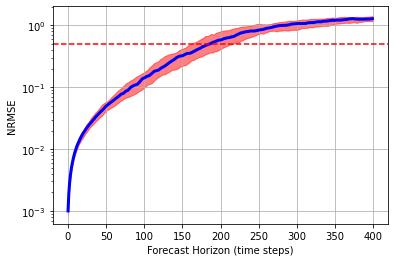

It takes around t = 1.85 for mean error to exceed 0.5


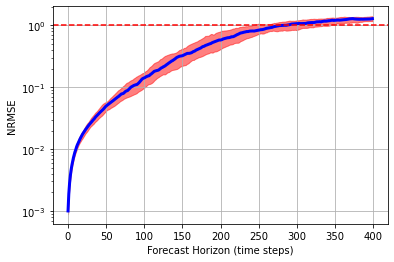

It takes around t = 2.81 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.018
Median NRMSE at t = 0.5: 0.050
Median NRMSE at t = 1: 0.143
Median NRMSE at t = 2: 0.582
Median NRMSE at t = 3: 1.069


In [38]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 1000
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [39]:
nn_size = 1000
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [40]:
L_forecast_train = 4; L_past = 1

In [41]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 3.30 | Train loss = 0.0001098 | Val loss =  1.1739211
Epoch 20: Time taken = 3.31 | Train loss = 0.0000561 | Val loss =  1.0788080
Epoch 30: Time taken = 3.34 | Train loss = 0.0000370 | Val loss =  1.0301419
Epoch 40: Time taken = 3.34 | Train loss = 0.0000275 | Val loss =  0.9899327
Epoch 50: Time taken = 3.35 | Train loss = 0.0000203 | Val loss =  0.9504477
Epoch 60: Time taken = 3.35 | Train loss = 0.0000174 | Val loss =  0.8867875
Epoch 70: Time taken = 3.35 | Train loss = 0.0000145 | Val loss =  0.9169835
Epoch 80: Time taken = 3.34 | Train loss = 0.0000135 | Val loss =  0.8931086
Epoch 90: Time taken = 3.35 | Train loss = 0.0000115 | Val loss =  0.9064269
Epoch 100: Time taken = 3.35 | Train loss = 0.0000108 | Val loss =  0.8206298
Epoch 103: Time taken = 3.35 | Train loss = 0.0000103 | Val loss =  0.8125660
Epoch 107: Time taken = 3.34 | Train loss = 0.0000102 | Val loss =  0.8076714
Epoch 110: Time taken = 3.34 | Train loss = 0.0000

In [42]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.12


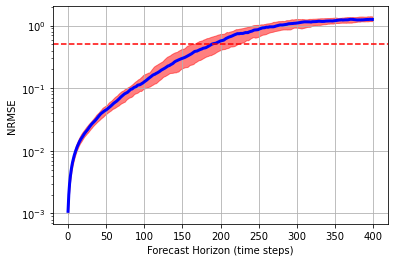

It takes around t = 1.88 for mean error to exceed 0.5


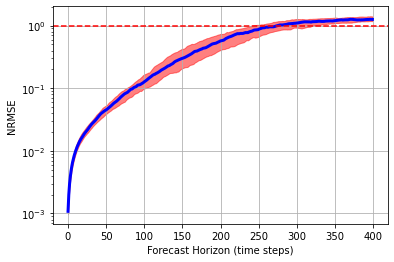

It takes around t = 2.75 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.018
Median NRMSE at t = 0.5: 0.045
Median NRMSE at t = 1: 0.127
Median NRMSE at t = 2: 0.571
Median NRMSE at t = 3: 1.099


In [43]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [44]:
L_forecast_train = 4; L_past = 4

In [45]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 5.68 | Train loss = 0.0001558 | Val loss =  1.3430552
Epoch 20: Time taken = 5.67 | Train loss = 0.0000806 | Val loss =  1.3102286
Epoch 30: Time taken = 5.70 | Train loss = 0.0000423 | Val loss =  1.2498636
Epoch 40: Time taken = 5.69 | Train loss = 0.0000273 | Val loss =  1.1834244
Epoch 50: Time taken = 5.68 | Train loss = 0.0000203 | Val loss =  1.1892927
Epoch 60: Time taken = 5.69 | Train loss = 0.0000153 | Val loss =  1.1203774
Epoch 70: Time taken = 5.70 | Train loss = 0.0000116 | Val loss =  1.0077869
Epoch 80: Time taken = 5.68 | Train loss = 0.0000098 | Val loss =  0.9642885
Epoch 90: Time taken = 5.66 | Train loss = 0.0000101 | Val loss =  0.9366841
Epoch 100: Time taken = 5.67 | Train loss = 0.0000087 | Val loss =  0.8971264
Epoch 101: Time taken = 5.66 | Train loss = 0.0000071 | Val loss =  0.8380120
Epoch 106: Time taken = 5.66 | Train loss = 0.0000069 | Val loss =  0.8256846
Epoch 110: Time taken = 5.67 | Train loss = 0.0000

In [46]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.13


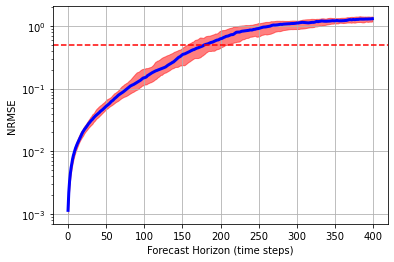

It takes around t = 1.79 for mean error to exceed 0.5


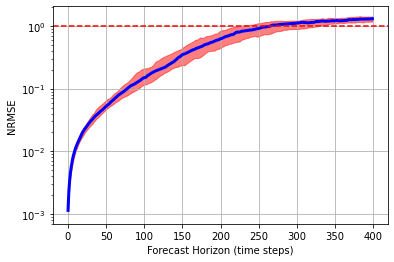

It takes around t = 2.65 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.021
Median NRMSE at t = 0.5: 0.053
Median NRMSE at t = 1: 0.149
Median NRMSE at t = 2: 0.628
Median NRMSE at t = 3: 1.120


In [47]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [48]:
L_forecast_train = 4; L_past = 8

In [49]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 8.38 | Train loss = 0.0001837 | Val loss =  2.4731545
Epoch 20: Time taken = 8.36 | Train loss = 0.0000627 | Val loss =  1.8184174
Epoch 30: Time taken = 8.35 | Train loss = 0.0000358 | Val loss =  1.6470509
Epoch 40: Time taken = 8.34 | Train loss = 0.0000234 | Val loss =  1.4365036
Epoch 50: Time taken = 8.34 | Train loss = 0.0000176 | Val loss =  1.1715604
Epoch 60: Time taken = 8.35 | Train loss = 0.0000131 | Val loss =  1.0370373
Epoch 70: Time taken = 8.36 | Train loss = 0.0000109 | Val loss =  0.9179279
Epoch 80: Time taken = 8.36 | Train loss = 0.0000087 | Val loss =  0.8863561
Epoch 90: Time taken = 8.36 | Train loss = 0.0000096 | Val loss =  0.8804458
Epoch 100: Time taken = 8.36 | Train loss = 0.0000080 | Val loss =  0.8731759
Epoch 101: Time taken = 8.36 | Train loss = 0.0000068 | Val loss =  0.7694465
Epoch 110: Time taken = 8.39 | Train loss = 0.0000059 | Val loss =  0.8115953
Epoch 120: Time taken = 8.38 | Train loss = 0.0000

In [50]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.11


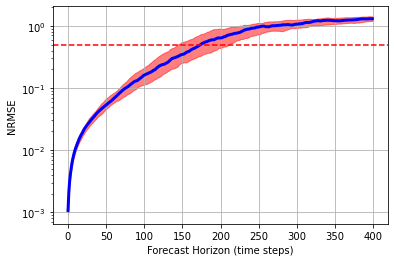

It takes around t = 1.75 for mean error to exceed 0.5


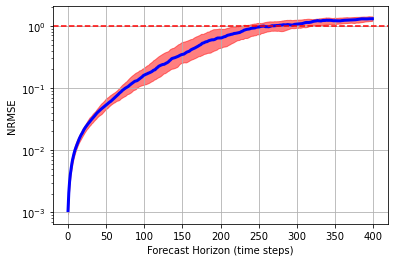

It takes around t = 2.67 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.020
Median NRMSE at t = 0.5: 0.053
Median NRMSE at t = 1: 0.161
Median NRMSE at t = 2: 0.638
Median NRMSE at t = 3: 1.065


In [51]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [52]:
L_forecast_train = 8; L_past = 1

In [53]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 6.11 | Train loss = 0.0003910 | Val loss =  1.1728572
Epoch 20: Time taken = 6.12 | Train loss = 0.0001614 | Val loss =  1.1250505
Epoch 30: Time taken = 6.11 | Train loss = 0.0001061 | Val loss =  1.1302222
Epoch 40: Time taken = 6.11 | Train loss = 0.0000716 | Val loss =  0.9932070
Epoch 50: Time taken = 6.10 | Train loss = 0.0000534 | Val loss =  0.9435453
Epoch 60: Time taken = 6.11 | Train loss = 0.0000455 | Val loss =  0.9273111
Epoch 70: Time taken = 6.10 | Train loss = 0.0000347 | Val loss =  0.8706614
Epoch 80: Time taken = 6.09 | Train loss = 0.0000319 | Val loss =  0.8246991
Epoch 90: Time taken = 6.09 | Train loss = 0.0000276 | Val loss =  0.8461223
Epoch 100: Time taken = 6.09 | Train loss = 0.0000281 | Val loss =  0.7858092
Epoch 101: Time taken = 6.10 | Train loss = 0.0000236 | Val loss =  0.7823391
Epoch 110: Time taken = 6.10 | Train loss = 0.0000237 | Val loss =  0.8435342
Epoch 112: Time taken = 6.10 | Train loss = 0.0000

In [54]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.11


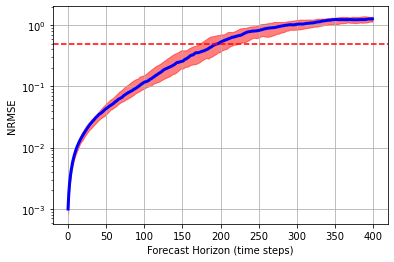

It takes around t = 1.98 for mean error to exceed 0.5


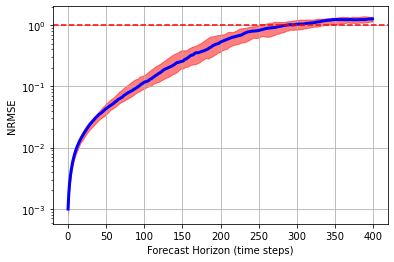

It takes around t = 2.88 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.016
Median NRMSE at t = 0.5: 0.043
Median NRMSE at t = 1: 0.117
Median NRMSE at t = 2: 0.529
Median NRMSE at t = 3: 1.033


In [55]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [56]:
L_forecast_train = 8; L_past = 4

In [57]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 8.47 | Train loss = 0.0004812 | Val loss =  1.1732334
Epoch 20: Time taken = 8.49 | Train loss = 0.0002049 | Val loss =  1.1522205
Epoch 30: Time taken = 8.49 | Train loss = 0.0001070 | Val loss =  1.1031917
Epoch 40: Time taken = 8.46 | Train loss = 0.0000671 | Val loss =  1.0340832
Epoch 50: Time taken = 8.46 | Train loss = 0.0000452 | Val loss =  0.9346176
Epoch 60: Time taken = 8.48 | Train loss = 0.0000376 | Val loss =  0.9237574
Epoch 70: Time taken = 8.48 | Train loss = 0.0000323 | Val loss =  0.9017195
Epoch 80: Time taken = 8.48 | Train loss = 0.0000255 | Val loss =  0.8907428
Epoch 90: Time taken = 8.48 | Train loss = 0.0000316 | Val loss =  0.8140647
Epoch 100: Time taken = 8.47 | Train loss = 0.0000183 | Val loss =  0.8683416
Epoch 104: Time taken = 8.47 | Train loss = 0.0000167 | Val loss =  0.7433347
Epoch 110: Time taken = 8.47 | Train loss = 0.0000149 | Val loss =  0.8044257
Epoch 120: Time taken = 8.48 | Train loss = 0.0000

In [58]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.08


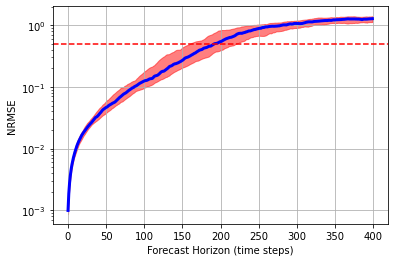

It takes around t = 1.92 for mean error to exceed 0.5


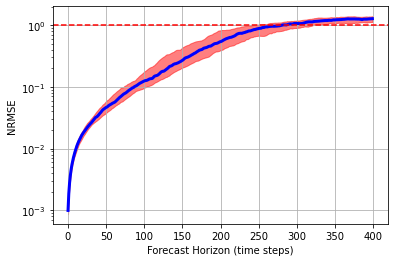

It takes around t = 2.80 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.018
Median NRMSE at t = 0.5: 0.047
Median NRMSE at t = 1: 0.125
Median NRMSE at t = 2: 0.542
Median NRMSE at t = 3: 1.065


In [59]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [60]:
L_forecast_train = 8; L_past = 8

In [61]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 11.03 | Train loss = 0.0005756 | Val loss =  1.3039825
Epoch 20: Time taken = 11.06 | Train loss = 0.0002062 | Val loss =  1.2995172
Epoch 30: Time taken = 11.06 | Train loss = 0.0001039 | Val loss =  1.0757623
Epoch 40: Time taken = 11.06 | Train loss = 0.0000553 | Val loss =  0.9636798
Epoch 50: Time taken = 11.08 | Train loss = 0.0000529 | Val loss =  0.9296626
Epoch 60: Time taken = 11.09 | Train loss = 0.0000315 | Val loss =  0.9160872
Epoch 70: Time taken = 11.09 | Train loss = 0.0000266 | Val loss =  0.8606620
Epoch 80: Time taken = 11.11 | Train loss = 0.0000214 | Val loss =  0.8067918
Epoch 90: Time taken = 11.10 | Train loss = 0.0000202 | Val loss =  0.8500308
Epoch 100: Time taken = 11.08 | Train loss = 0.0000213 | Val loss =  0.7950832
Epoch 108: Time taken = 11.08 | Train loss = 0.0000195 | Val loss =  0.7497743
Epoch 110: Time taken = 11.08 | Train loss = 0.0000165 | Val loss =  0.7604728
Epoch 114: Time taken = 11.08 | Train 

In [62]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.09


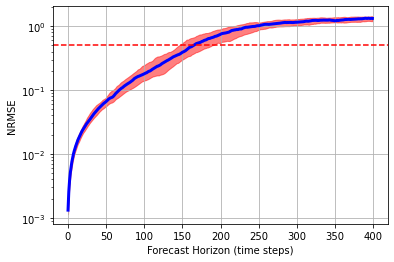

It takes around t = 1.65 for mean error to exceed 0.5


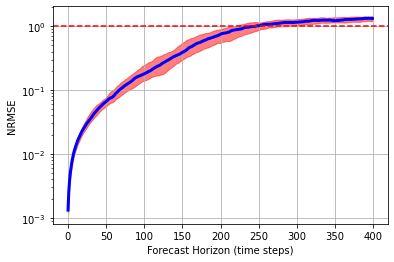

It takes around t = 2.47 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.025
Median NRMSE at t = 0.5: 0.066
Median NRMSE at t = 1: 0.180
Median NRMSE at t = 2: 0.747
Median NRMSE at t = 3: 1.150


In [63]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [64]:
L_forecast_train = 16; L_past = 1

In [65]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 11.69 | Train loss = 0.0017970 | Val loss =  1.2484913
Epoch 20: Time taken = 11.66 | Train loss = 0.0006692 | Val loss =  1.1154861
Epoch 30: Time taken = 11.65 | Train loss = 0.0003609 | Val loss =  1.0689903
Epoch 40: Time taken = 11.67 | Train loss = 0.0001977 | Val loss =  0.9772734
Epoch 50: Time taken = 11.67 | Train loss = 0.0001475 | Val loss =  0.9167426
Epoch 60: Time taken = 11.65 | Train loss = 0.0000973 | Val loss =  0.8957046
Epoch 70: Time taken = 11.65 | Train loss = 0.0000899 | Val loss =  0.8986018
Epoch 80: Time taken = 11.64 | Train loss = 0.0000764 | Val loss =  0.8447739
Epoch 90: Time taken = 11.65 | Train loss = 0.0000922 | Val loss =  0.8709919
Epoch 100: Time taken = 11.64 | Train loss = 0.0000612 | Val loss =  0.8249934
Epoch 103: Time taken = 11.64 | Train loss = 0.0000888 | Val loss =  0.8040134
Epoch 106: Time taken = 11.65 | Train loss = 0.0000647 | Val loss =  0.8000900
Epoch 110: Time taken = 11.64 | Train 

In [66]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.12


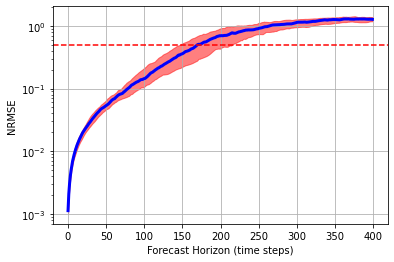

It takes around t = 1.70 for mean error to exceed 0.5


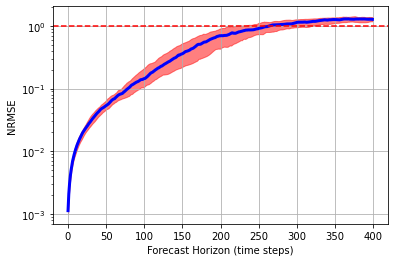

It takes around t = 2.65 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.020
Median NRMSE at t = 0.5: 0.053
Median NRMSE at t = 1: 0.144
Median NRMSE at t = 2: 0.693
Median NRMSE at t = 3: 1.134


In [67]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [68]:
L_forecast_train = 16; L_past = 4

In [69]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 14.20 | Train loss = 0.0020893 | Val loss =  1.2320209
Epoch 20: Time taken = 14.18 | Train loss = 0.0008152 | Val loss =  1.1582347
Epoch 30: Time taken = 14.17 | Train loss = 0.0003767 | Val loss =  1.0537206
Epoch 40: Time taken = 14.18 | Train loss = 0.0002081 | Val loss =  0.9658163
Epoch 50: Time taken = 14.19 | Train loss = 0.0001846 | Val loss =  0.9825264
Epoch 60: Time taken = 14.18 | Train loss = 0.0001191 | Val loss =  0.9296511
Epoch 70: Time taken = 14.17 | Train loss = 0.0001100 | Val loss =  0.9505774
Epoch 80: Time taken = 14.17 | Train loss = 0.0000701 | Val loss =  0.8736368
Epoch 90: Time taken = 14.26 | Train loss = 0.0000876 | Val loss =  0.8953937
Epoch 100: Time taken = 14.25 | Train loss = 0.0000476 | Val loss =  0.7931189
Epoch 110: Time taken = 14.25 | Train loss = 0.0000547 | Val loss =  0.8347957
Epoch 120: Time taken = 14.28 | Train loss = 0.0000740 | Val loss =  0.7877843
EARLY STOPPING. Epoch 123: Train loss 

In [70]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.07


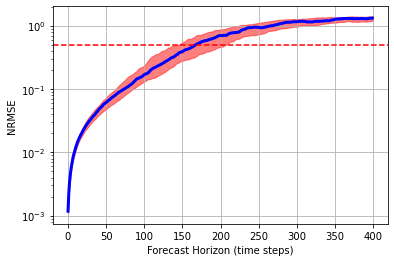

It takes around t = 1.68 for mean error to exceed 0.5


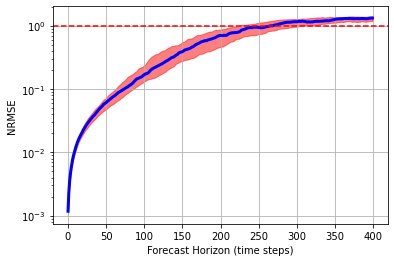

It takes around t = 2.66 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.022
Median NRMSE at t = 0.5: 0.061
Median NRMSE at t = 1: 0.169
Median NRMSE at t = 2: 0.700
Median NRMSE at t = 3: 1.157


In [71]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [72]:
L_forecast_train = 16; L_past = 8

In [73]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 16.33 | Train loss = 0.0022895 | Val loss =  1.2635843
Epoch 20: Time taken = 16.32 | Train loss = 0.0007734 | Val loss =  1.1670030
Epoch 30: Time taken = 16.37 | Train loss = 0.0003470 | Val loss =  1.0646802
Epoch 40: Time taken = 16.36 | Train loss = 0.0002173 | Val loss =  1.0351040
Epoch 50: Time taken = 16.34 | Train loss = 0.0001524 | Val loss =  0.9429477
Epoch 60: Time taken = 16.35 | Train loss = 0.0001081 | Val loss =  0.9648905
Epoch 70: Time taken = 16.31 | Train loss = 0.0000834 | Val loss =  0.8749003
Epoch 80: Time taken = 16.31 | Train loss = 0.0000843 | Val loss =  0.9052661
Epoch 90: Time taken = 16.34 | Train loss = 0.0001012 | Val loss =  0.8350955
Epoch 100: Time taken = 16.36 | Train loss = 0.0000700 | Val loss =  0.8120797
Epoch 110: Time taken = 16.36 | Train loss = 0.0000594 | Val loss =  0.7629405
Epoch 115: Time taken = 16.33 | Train loss = 0.0000574 | Val loss =  0.7529958
Epoch 120: Time taken = 16.34 | Train 

In [74]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.08


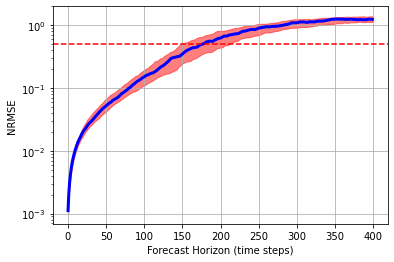

It takes around t = 1.76 for mean error to exceed 0.5


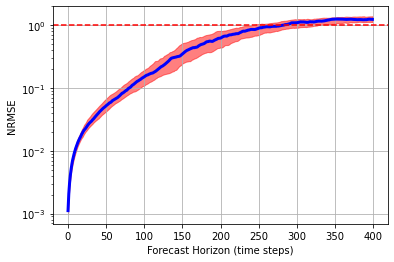

It takes around t = 2.81 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.020
Median NRMSE at t = 0.5: 0.052
Median NRMSE at t = 1: 0.151
Median NRMSE at t = 2: 0.627
Median NRMSE at t = 3: 1.101


In [75]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 1000  
L_forecast_train = 8  
L_past = 1

In [76]:
nn_size = 1000
L_forecast_train = 8
L_past = 1

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5, 1e-6] # Learning rate schedule
epoch_list = [400, 200, 200, 200]  # Number of epochs for each learning rate

In [77]:
params, lstm_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 50)

Backpropogation start

Epoch 10: Time taken = 6.05 | Train loss = 0.0003910 | Val loss =  1.1728572
Epoch 20: Time taken = 6.08 | Train loss = 0.0001614 | Val loss =  1.1250505
Epoch 30: Time taken = 6.08 | Train loss = 0.0001061 | Val loss =  1.1302222
Epoch 40: Time taken = 6.11 | Train loss = 0.0000716 | Val loss =  0.9932070
Epoch 50: Time taken = 6.08 | Train loss = 0.0000534 | Val loss =  0.9435453
Epoch 60: Time taken = 6.10 | Train loss = 0.0000455 | Val loss =  0.9273111
Epoch 70: Time taken = 6.12 | Train loss = 0.0000347 | Val loss =  0.8706614
Epoch 80: Time taken = 6.12 | Train loss = 0.0000319 | Val loss =  0.8246991
Epoch 90: Time taken = 6.11 | Train loss = 0.0000276 | Val loss =  0.8461223
Epoch 100: Time taken = 6.12 | Train loss = 0.0000281 | Val loss =  0.7858092
Epoch 101: Time taken = 6.12 | Train loss = 0.0000236 | Val loss =  0.7823391
Epoch 110: Time taken = 6.12 | Train loss = 0.0000237 | Val loss =  0.8435342
Epoch 112: Time taken = 6.11 | Train loss = 0.0000

In [78]:
mean_pred = get_test_pred(X_test, params, lstm_fx)

Testing complete. Time taken: 1.12


In [79]:
save_obj(params, "results/lstm", "best_params.pkl")
save_obj(mean_pred, "results/lstm", "best_mu_preds.pkl")

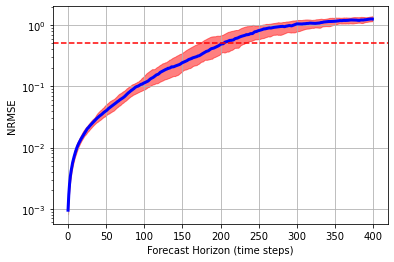

It takes around t = 2.04 for mean error to exceed 0.5


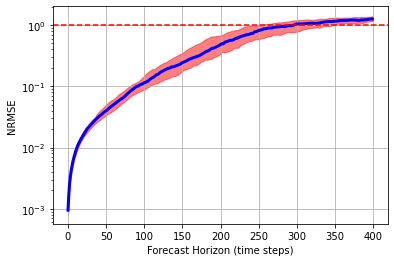

It takes around t = 2.96 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.016
Median NRMSE at t = 0.5: 0.040
Median NRMSE at t = 1: 0.114
Median NRMSE at t = 2: 0.482
Median NRMSE at t = 3: 1.045


In [80]:
desc_name = "lstm_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [17]:
# nn_size = 1000
# _, process, forecast = LSTM(nn_size, data_dim)       # LSTM Network
# process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
# forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [18]:
# params = load_obj("results/lstm/best_params.pkl")

In [19]:
# mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))

Testing complete. Time taken: 2.01


In [81]:
save_obj(mean_pred, "results", "lstm_pred.pkl")

In [82]:
mean_pred = load_obj("results/lstm_pred.pkl")

In [83]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

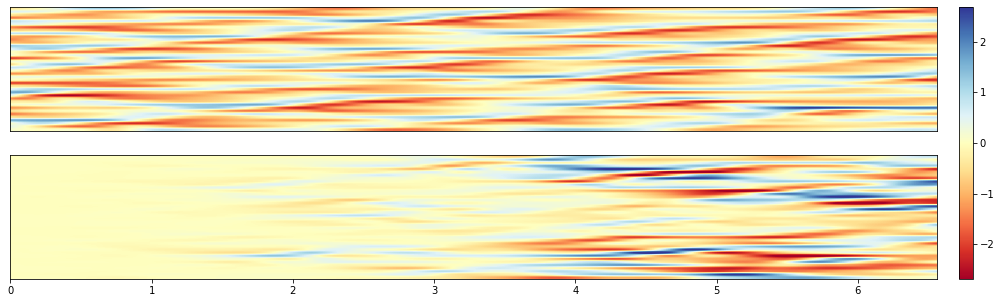

In [84]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_lstm_edited", pred_only = True)

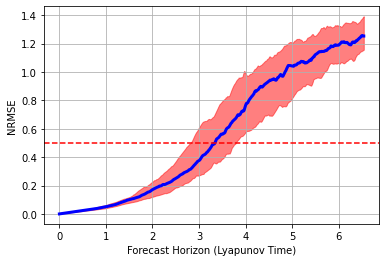

It takes around 3.34 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.024
Median NRMSE at 1.0 Lyapunov Time: 0.051
Median NRMSE at 2.0 Lyapunov Time: 0.172
Median NRMSE at 5.0 Lyapunov Time: 1.042


In [85]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "lorenz_lstm_ph_edited")
print()
res_single.get_loss()